# LSTM-CNN Sentiment Analysis on Rotten Tomatoes Reviews

Student ID: 23C11024

Student name: Chiêm Quốc Hùng

## Introduction

This is a homework for HCMUS' Deep Learning course. The homework is based on Dr. Nguyen Tien Huy's work on the paper Multi-channel LSTM-CNN model for Vietnamesesentiment analysis ([link here](https://www.researchgate.net/publication/321259272_Multi-channel_LSTM-CNN_model_for_Vietnamese_sentiment_analysis)).

The datasets can be found in the links below:
1. Base dataset (~400mb): [rotten_tomatoes_movie_reviews.csv](https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews)
2. Additional testing dataset (~200mb): [rotten_tomatoes_critic_reviews.csv](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset)

## Import dataset

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, concatenate, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [8]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
data = pd.read_csv("./rotten_tomatoes_movie_reviews.csv")
data.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


## Data cleaning

In [10]:
# Drop missing reviewText rows
data = data.dropna(subset=['reviewText'])

# Only use reviewState (result) and reviewText columns
data = data[['reviewState', 'reviewText']]

# Encode sentiment
data['sentiment'] = data['reviewState'].apply(lambda x: 1 if x == 'fresh' else 0)

data.head()

,reviewState,reviewText,sentiment
0,fresh,Timed to be just long enough for most youngste...,1
1,rotten,It doesn't matter if a movie costs 300 million...,0
2,fresh,The choreography is so precise and lifelike at...,1
3,rotten,The film's out-of-touch attempts at humor may ...,0
4,fresh,Its clumsy determination is endearing and some...,1


## Training and testing data preparation

In [11]:
# Extract texts and labels
texts = data['reviewText'].values
labels = data['sentiment'].values

# Parameters
max_features = 10000
max_len = 100
embedding_dim = 100
num_classes = 2

# Text tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences
data = pad_sequences(sequences, maxlen=max_len)

# Convert labels to categorical
labels = to_categorical(np.asarray(labels))

## Train-test split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=69)

## Model layers

In [12]:
# Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim,
                           input_length=max_len)

# LSTM layer branch
lstm_input = Input(shape=(max_len,))
embedded_sequences_lstm = embedding_layer(lstm_input)
lstm_out = LSTM(128)(embedded_sequences_lstm)

# CNN layer branch
cnn_input = Input(shape=(max_len,))
embedded_sequences_cnn = embedding_layer(cnn_input)
cnn_out = Conv1D(128, 5, activation='relu')(embedded_sequences_cnn)
cnn_out = GlobalMaxPooling1D()(cnn_out)

# Concatenate LSTM and CNN outputs
merged = concatenate([lstm_out, cnn_out])
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.5)(merged)
pred = Dense(num_classes, activation='softmax')(merged)

# Build model
model = Model(inputs=[lstm_input, cnn_input], outputs=pred)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/hungcq/study/lstm_cnn_sentiment/.conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-06-23 14:21:47.907497: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:21:47.907669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:21:47.907710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 14:21:48.083929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could n

## Train and evaluate model

In [13]:
# Train model
history = model.fit([x_train, x_train], y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate model
score = model.evaluate([x_test, x_test], y_test)
print(f"Test accuracy: {score[1]}")

Epoch 1/5


2024-06-23 14:21:50.945196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


27515/27515 ━━━━━━━━━━━━━━━━━━━━ 867s 31ms/step - accuracy: 0.8111 - loss: 0.4094 - val_accuracy: 0.8560 - val_loss: 0.3252
Epoch 2/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 866s 31ms/step - accuracy: 0.8640 - loss: 0.3169 - val_accuracy: 0.8614 - val_loss: 0.3142
Epoch 3/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 877s 32ms/step - accuracy: 0.8768 - loss: 0.2915 - val_accuracy: 0.8638 - val_loss: 0.3109
Epoch 4/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 862s 31ms/step - accuracy: 0.8871 - loss: 0.2694 - val_accuracy: 0.8639 - val_loss: 0.3191
Epoch 5/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 861s 31ms/step - accuracy: 0.8961 - loss: 0.2507 - val_accuracy: 0.8624 - val_loss: 0.3231
8599/8599 ━━━━━━━━━━━━━━━━━━━━ 70s 8ms/step - accuracy: 0.8618 - loss: 0.3223
Test accuracy: 0.8618234395980835


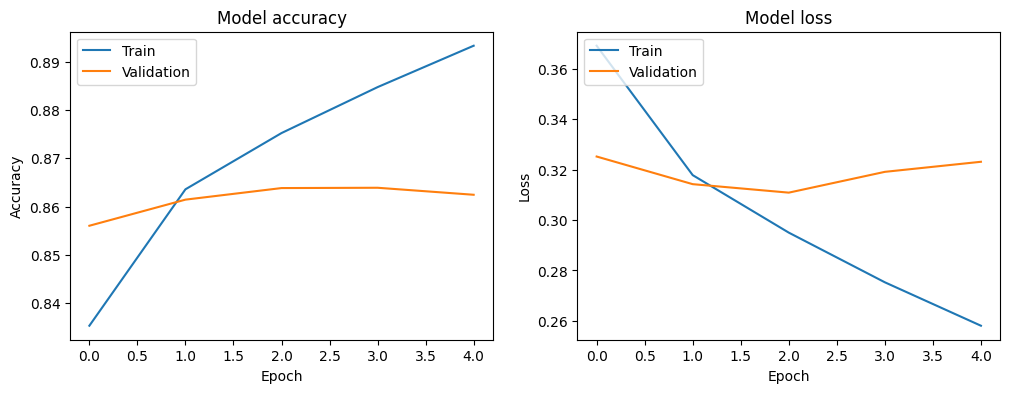

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Additional testing

In [15]:
data = pd.read_csv("./rotten_tomatoes_critic_reviews.csv")
data.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [16]:
# Drop missing review_content rows
data = data.dropna(subset=['review_content'])

# Only use review_type (result) and review_content columns
data = data[['review_type', 'review_content']]

# Encode sentiment
data['sentiment'] = data['review_type'].apply(lambda x: 1 if x == 'Fresh' else 0)

data.head()

,review_type,review_content,sentiment
0,Fresh,A fantasy adventure that fuses Greek mythology...,1
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,Fresh,With a top-notch cast and dazzling special eff...,1
3,Fresh,Whether audiences will get behind The Lightnin...,1
4,Rotten,What's really lacking in The Lightning Thief i...,0


In [18]:
# Extract texts and labels
texts = data['review_content'].values
labels = data['sentiment'].values

# Text tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences
data = pad_sequences(sequences, maxlen=max_len)

# Convert labels to categorical
labels = to_categorical(np.asarray(labels))

# ## Train-test split
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=69)

In [19]:
# Evaluate model
score = model.evaluate([data, data], labels)
print(f"Test accuracy: {score[1]}")

33257/33257 ━━━━━━━━━━━━━━━━━━━━ 273s 8ms/step - accuracy: 0.5530 - loss: 1.0205
Test accuracy: 0.5556172728538513
